First, install the necessary packages.

In [1]:
import sys
!{sys.executable} -m pip install --quiet numpy
!{sys.executable} -m pip install --quiet matplotlib
!{sys.executable} -m pip install --quiet wnutils
!{sys.executable} -m pip install --quiet requests

import os, io, requests

Now import the packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wnutils.xml as wx
from matplotlib import animation 
from IPython.display import HTML

Define a routine to compute the neutron separation energies (along with the neutron number).  Sort by neutron number to ensure proper calculation of separation energies.

In [3]:
def calc_seps(neutron, nuclides):
    nm = []
    sep = []
    n = []
    m = []

    m_n = neutron['n']['mass excess']

    for sp in nuclides:
        m.append(nuclides[sp]['mass excess'])
        n.append(nuclides[sp]['n'])
        
    zipped_lists = zip(n, m)
    sorted_pairs = sorted(zipped_lists)

    tuples = zip(*sorted_pairs)
    n, m = [list(tuple) for tuple in tuples]

    for i in range(1, len(m)):
        sep.append(m[i-1] + m_n - m[i]) 
    
    return (n[1:len(n)], sep)

Now define a routine to compute the normalized $(n,\gamma)-(\gamma,n)$ equilibrium abundances for a given set of separation energies, and a given $\mu_n'$ and $T_9$.

In [4]:
def calc_y(N, seps, mu_n_prime, T9):
    kT = T9 / 11.605
    y = []
    for i in range(len(seps)):
        if i == 0:
            y.append((seps[i] + mu_n_prime)/kT)
        else:
            y.append(y[i-1] + (seps[i] + mu_n_prime)/kT)
        
    ym = np.max(y)
    y -= ym
    
    y = np.exp(y)
    
    return y / np.sum(y)

Begin by reading in the XML.  You may read the data over the web from an appropriate URL (the default for this notebook downloads the Webnucleo V2.2 Reaclib data from [OSF](https://osf.io/kjnct/)) or from a local directory (as in the comment).  If you are running the notebook on Google Colab, you can upload the data to the work directory by clicking on the directory tab to the left and then clicking the upload symbol.  On Colab, you may also read the file from Google Drive (click the Drive icon and follow the instructions).

In [5]:
xml = wx.Xml(io.BytesIO(requests.get('https://osf.io/kyhbs/download').content))
#xml= wx.Xml("example.xml")

xml.validate()

Select an atomic number.

In [12]:
Z = 50

Create the plot of $S_n$ vs. $N$ and the plot of the normalized $(n,\gamma)-(\gamma,n)$ equilibrium abundances vs. N.

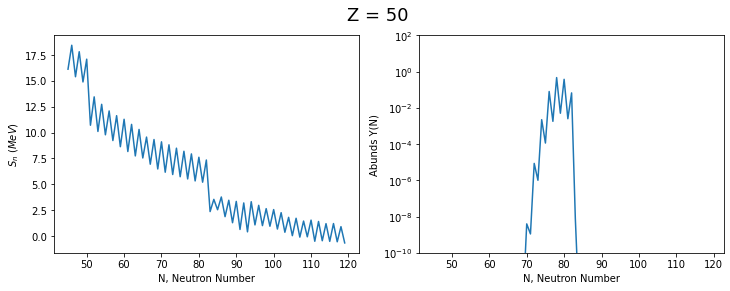

In [13]:
neutron = xml.get_nuclide_data("[z = 0 and a = 1]")
nuclides = xml.get_nuclide_data('[z =' + str(Z) + ']')

if not nuclides:
    print('Z = ' + str(Z) + ' not present in nuclear data')
else:
    N, seps = calc_seps(neutron, nuclides)
    abunds = calc_y(N, seps, -6.5, 3)
    
fig, ax = plt.subplots(ncols = 2, figsize=(12,4))
fig.suptitle('Z = ' + str(Z), fontsize = 18)
ylabel = (('$S_n\ (MeV)$','Abunds Y(N)'))
data = np.array(list(zip(seps,abunds)))
ax[1].set_yscale('log')
ax[1].set_ylim(1.e-10,1.e2)

for i in range(2):
    ax[i].set_xlabel('N, Neutron Number')
    ax[i].set_ylabel(ylabel[i])
    ax[i].plot(N, data[:,i])

Now, create a new frame for the movie.

In [14]:
fig = plt.figure(figsize=(8,6))

ax1 = plt.subplot(211)

ax1.set_ylabel(r'Energy [MeV]')
ax1.set_xlim([np.min(N)-3,np.max(N)+3])
ax1.set_ylim([np.min(seps)-2,np.max(seps)+2])
txt_title = ax1.set_title('',fontsize=10)
line1, = ax1.plot([], [], label = r'-$\mu_n^{\prime}$')
line2, = ax1.plot([], [], label = r'$S_n$')
ax1.legend()

ax2 = plt.subplot(212)

ax2.set_ylabel(r'Abunds ratio')
ax2.set_xlabel('Neutron number N')
ax2.set_xlim([np.min(N)-3,np.max(N)+3])
ax2.set_ylim([1.e-20,1.e2])
ax2.set_yscale('log')
line3, = ax2.plot([], [], label = r'Abunds ratio')
plt.legend()
plt.close()

Create a movie to show the the effects of a changing temperature $T_9$ and a chaning $\mu_p'$

In [15]:
def make_movie(i):
    
    mn = -Mu_n[i]*np.ones(len(N))
    t9 = T_9[i]
    for j in range(len(Mu_n)):
        abunds = np.zeros([len(Mu_n),len(N)])
        abunds[i,:] = calc_y(N, seps, Mu_n[i], t9)
    
    txt_title.set_text(r"Z = {Z};  $T_9$ = {T9};  $-\mu_n'$ = {mn} [MeV]".format(Z = str(Z),T9 = "%.1f" %T_9[i], mn = "%.1f" %-Mu_n[i]))

    line1.set_data(N, mn)
    line2.set_data(N, seps)
    line3.set_data(N, abunds[i,:])
    
    return (line1, line2, line3)

In [16]:
Mu_n = np.linspace(-17,5,50)
T_9 = 2*np.ones(len(Mu_n)) 

#T_9 = np.linspace(4,2,28) #for a decreasing temperature 
#Mu_n = -10*np.ones(len(T_9)) #for a constant mu_p_prime 

In [17]:
args = (T_9, Mu_n)
anim = animation.FuncAnimation(fig, make_movie, frames=len(Mu_n), blit=True, repeat=False)
HTML(anim.to_jshtml())